In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc
import maxfuse as mf

import seaborn as sns
import os


/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [2]:
# read in protein data
data_dir = './../../../neighborhood/CRC_related/'
protein = pd.read_csv(os.path.join(data_dir, 'crc_codex/CRC_clusters_neighborhoods_markersV2.csv')) # ~258,000 codex cells

In [3]:
sum(protein['ClusterName'] == 'tumor cells')

47602

# Remove tumor cells in CODEX

In [4]:
protein_new = protein[protein['ClusterName'] != 'tumor cells']

In [5]:
protein_new.shape

(210783, 101)

In [6]:
protein.shape

(258385, 101)

In [7]:
protein_new = protein_new[protein_new['ClusterName'] != 'dirt']

In [8]:
protein_new.shape

(203426, 101)

# Rename protein

In [9]:
protein_features = list(protein.columns[13:62]) + list(protein.columns[70:79])
protein_new_exp = protein_new[protein_features]

In [11]:
import re
protein_new_exp = protein_new_exp.rename(columns=lambda x: re.sub(' -.*','',x))

In [12]:
# convert to AnnData
protein_adata = ad.AnnData(
    protein_new_exp.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein_new_exp.columns

In [13]:
protein_adata.var_names

Index(['CD44', 'FOXP3', 'CD8', 'p53', 'GATA3', 'CD45', 'T-bet', 'beta-catenin',
       'HLA-DR', 'PD-L1', 'Ki67', 'CD45RA', 'CD4', 'CD21', 'MUC-1', 'CD30',
       'CD2', 'Vimentin', 'CD20', 'LAG-3', 'Na-K-ATPase', 'CD5', 'IDO-1',
       'Cytokeratin', 'CD11b', 'CD56', 'aSMA', 'BCL-2', 'CD25', 'CD11c',
       'PD-1', 'Granzyme B', 'EGFR', 'VISTA', 'CD15', 'ICOS', 'Synaptophysin',
       'GFAP', 'CD7', 'CD3', 'Chromogranin A', 'CD163', 'CD45RO', 'CD68',
       'CD31', 'Podoplanin', 'CD34', 'CD38', 'CD138', 'HOECHST1:Cyc_1_ch_1',
       'CDX2', 'Collagen IV', 'CD194', 'MMP9', 'CD71', 'CD57', 'MMP12',
       'DRAQ5:Cyc_23_ch_4'],
      dtype='object')

In [14]:
protein_adata.X.shape

(203426, 58)

# Remove tumor cells in RNA

In [15]:
data_dir = './../../../neighborhood/CRC_related/'
counts = sc.read_10x_h5(os.path.join(data_dir, 'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit.h5'))

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/scanpy/readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
cluster = pd.read_csv(os.path.join(data_dir, 'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit_cluster.csv'))
cluster.head()

,sampleID,batchID,clTopLevel,clMidwayPr,cl295v11SubShort,cl295v11SubFull
0,C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
1,C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
2,C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG,C103_T_1_1_0_c1_v2,Epi,Epi,cE03,cE03 (Stem/TA-like prolif)
3,C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
4,C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)


In [19]:
cluster.clMidwayPr.value_counts()

Epi             168295
Plasma           37809
TCD4             34598
B                25660
TCD8             23486
Macro            20280
Mono             14242
Tgd               9383
Endo              7520
DC                5549
Fibro             5231
TZBTB16           4742
NK                3924
Mast              3834
Granulo           2043
Peri              1525
SmoothMuscle       881
ILC                832
Schwann            281
Name: clMidwayPr, dtype: int64

In [20]:
cancer_cell_index = cluster[cluster.clMidwayPr == 'Epi'].index

# Remove normal tissues in RNA

In [20]:
metapat = pd.read_csv(os.path.join(data_dir,'hacohen_scrna/data/GSE178341_crc10x_full_c295v4_submit_metatables.csv'))
metapat.head()

,cellID,SPECIMEN_TYPE,SOURCE_HOSPITAL,TISSUE_PROCESSING_TEAM,PROCESSING_TYPE,SINGLECELL_TYPE,PatientTypeID,HistologicTypeSimple,MMR_IHC,MMRStatus,...,NodeStatus_detailed,NodeStatusSimple,MetastasisStatus,TumorSize,SizeQuantile,PID,Sex,Age,Ethnicity,Race
0,C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,T,MGH,Hacohen,unsorted,SC3Pv2,C103_T,Adenocarcinoma,preserved,MMRp,...,N0,Nneg,not entered (Mx),2.5,1.0,C103,M,45,No,Asian
1,C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,T,MGH,Hacohen,unsorted,SC3Pv2,C103_T,Adenocarcinoma,preserved,MMRp,...,N0,Nneg,not entered (Mx),2.5,1.0,C103,M,45,No,Asian
2,C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG,T,MGH,Hacohen,unsorted,SC3Pv2,C103_T,Adenocarcinoma,preserved,MMRp,...,N0,Nneg,not entered (Mx),2.5,1.0,C103,M,45,No,Asian
3,C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT,T,MGH,Hacohen,unsorted,SC3Pv2,C103_T,Adenocarcinoma,preserved,MMRp,...,N0,Nneg,not entered (Mx),2.5,1.0,C103,M,45,No,Asian
4,C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC,T,MGH,Hacohen,unsorted,SC3Pv2,C103_T,Adenocarcinoma,preserved,MMRp,...,N0,Nneg,not entered (Mx),2.5,1.0,C103,M,45,No,Asian


In [21]:
metapat.HistologicTypeSimple.value_counts()

Adenocarcinoma                                          228103
Normal colon                                            112864
Adenocarcinoma;Mucinous                                  18813
Medullary                                                 4717
Adenocarcinoma;Mucinous;Neuroendocrine                    3091
Adenocarcinoma;Medullary (with solid growth pattern)      2527
Name: HistologicTypeSimple, dtype: int64

In [22]:
normal_tissue_index = metapat[metapat.HistologicTypeSimple == 'Normal colon'].index

In [24]:
rows_to_remove = list(cancer_cell_index) + list(normal_tissue_index)

In [25]:
from tqdm import tqdm
filtered_rows = []
for i in tqdm(range(counts.n_obs), desc="Filtering rows"):
    if i not in rows_to_remove:
        filtered_rows.append(i)

Filtering rows: 100%|██████████████████| 370115/370115 [10:24<00:00, 593.04it/s]


In [26]:
filtered_adata = counts[filtered_rows, :]

In [27]:
rna_adata = filtered_adata

In [28]:
rna_adata.X.shape

(144035, 43113)

In [29]:
counts.X.shape

(370115, 43113)

In [30]:
rna_adata.var_names

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RNU6-1100P', 'RP11-34P13.9',
       'AP006222.2',
       ...
       'ADT-CD56', 'ADT-CD11b', 'ADT-CD15', 'ADT-CD163', 'ADT-CD20',
       'ADT-TCRgd', 'ADT-TCRab', 'ADT-CD1c', 'ADT-CD141', 'ADT-HLA-DR'],
      dtype='object', length=43113)

In [31]:
rna_adata.var_names_make_unique()

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-5', 'SNORD116-6']
  warnings.warn(
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [32]:
rna_adata.X.shape

(144035, 43113)

In [97]:
rna_adata.write(os.path.join(data_dir, "hacohen_scrna/data/rna_processed_0905.h5"))

# Name conversion between protein and RNA

In [33]:
correspondence = pd.read_csv(os.path.join(data_dir, 'pro_rna_conv_0615_23.csv'))
#correspondence = pd.read_csv('./../CRC_related/protein_rna_name_conversionV8.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [34]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [35]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()
print([rna_shared.shape,protein_shared.shape])

[(144035, 60), (210783, 60)]


/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [37]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.01) 
    & (protein_shared.X.std(axis=0) > 0.01)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(144035, 60), (210783, 60)]


In [38]:
# process rna_shared
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)
rna_shared = rna_shared.X.copy()

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [39]:
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)
protein_shared = protein_shared.X.copy()

In [40]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [41]:
# process all protein features
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

In [42]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

In [43]:
rna_active.shape

(144035, 5000)

In [44]:
protein_active.shape

(210783, 58)

## Fitting MaxFuse

### Step I: preparations

In [45]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [46]:
fusor.split_into_batches(
    max_outward_size=8000,
    matching_ratio=4,
    metacell_size=2,
    verbose=True
)

The first data is split into 8 batches, average batch size is 18004, and max batch size is 18007.
The second data is split into 6 batches, average batch size is 35130, and max batch size is 35133.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '1<->0', '1<->1', '1<->2', '1<->3', '1<->4', '1<->5', '2<->0', '2<->1', '2<->2', '2<->3', '2<->4', '2<->5', '3<->0', '3<->1', '3<->2', '3<->3', '3<->4', '3<->5', '4<->0', '4<->1', '4<->2', '4<->3', '4<->4', '4<->5', '5<->0', '5<->1', '5<->2', '5<->3', '5<->4', '5<->5', '6<->0', '6<->1', '6<->2', '6<->3', '6<->4', '6<->5', '7<->0', '7<->1', '7<->2', '7<->3', '7<->4', '7<->5'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

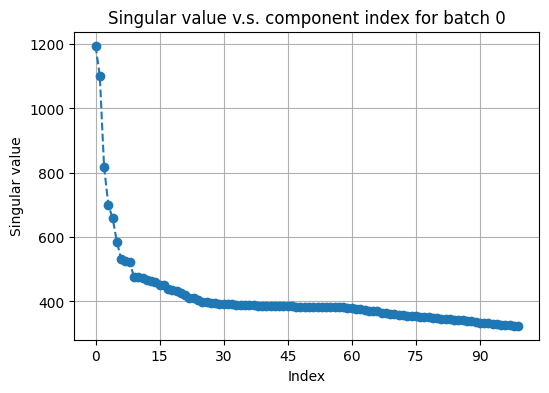

In [47]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 3'}, xlabel='Index', ylabel='Singular value'>)

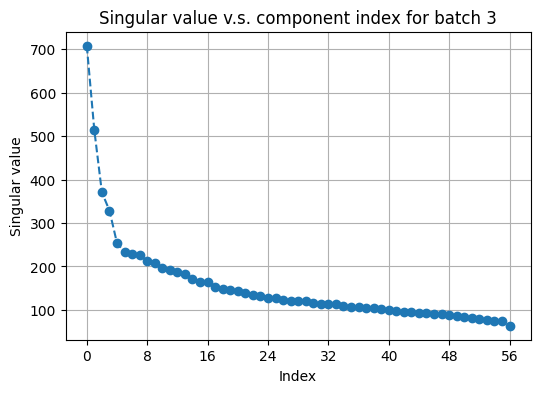

In [48]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [49]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Now at batch 1...
Metacell clustering finished!
Now at batch 2...
Metacell clustering finished!
Now at batch 3...
Metacell clustering finished!
Now at batch 4...
Metacell clustering finished!
Now at batch 5...
Metacell clustering finished!
Now at batch 6...
Metacell clustering finished!
Now at batch 7...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Now at batch 2...
Now at batch 3...
Now at batch 4...
Now at batch 5...
Now at batch 6...
Now at batch 7...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at bat

### Step II: finding initial pivots

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

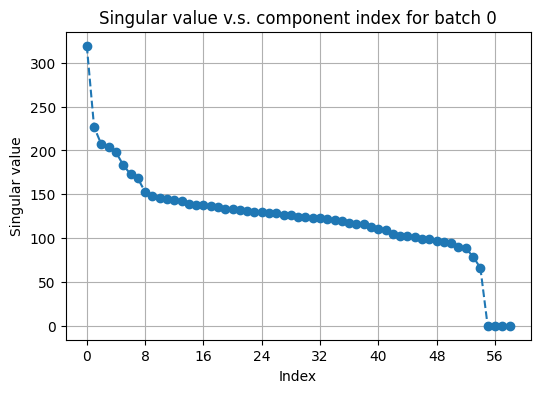

In [50]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 4'}, xlabel='Index', ylabel='Singular value'>)

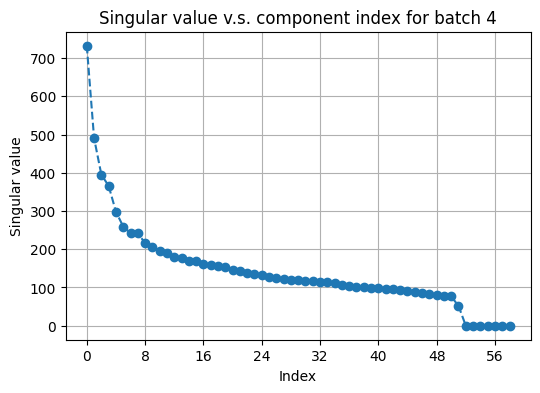

In [51]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [52]:
fusor.find_initial_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 1<->3...
Now at batch 1<->4...
Now at batch 1<->5...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Now at batch 2<->3...
Now at batch 2<->4...
Now at batch 2<->5...
Now at batch 3<->0...
Now at batch 3<->1...
Now at batch 3<->2...
Now at batch 3<->3...
Now at batch 3<->4...
Now at batch 3<->5...
Now at batch 4<->0...
Now at batch 4<->1...
Now at batch 4<->2...
Now at batch 4<->3...
Now at batch 4<->4...
Now at batch 4<->5...
Now at batch 5<->0...
Now at batch 5<->1...
Now at batch 5<->2...
Now at batch 5<->3...
Now at batch 5<->4...
Now at batch 5<->5...
Now at batch 6<->0...
Now at batch 6<->1...
Now at batch 6<->2...
Now at batch 6<->3...
Now at batch 6<->4...
Now at batch 6<->5...
Now at batch 7<->0...
Now at batch 7<->1...
Now at batch 7<->2...
Now at bat

### Step III: finding refined pivots

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 3<->4'}, xlabel='Index', ylabel='Canonical correlation'>)

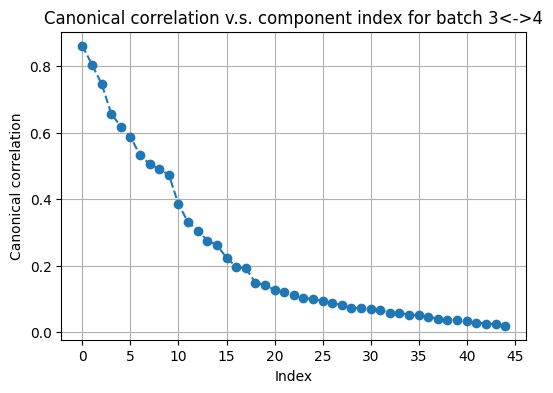

In [53]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

In [54]:
fusor.refine_pivots(
    wt1=0.3, wt2=0.3,
    svd_components1=30, svd_components2=None,
    cca_components=25,
    n_iters=1,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 1<->3...
Now at batch 1<->4...
Now at batch 1<->5...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Now at batch 2<->3...
Now at batch 2<->4...
Now at batch 2<->5...
Now at batch 3<->0...
Now at batch 3<->1...
Now at batch 3<->2...
Now at batch 3<->3...
Now at batch 3<->4...
Now at batch 3<->5...
Now at batch 4<->0...
Now at batch 4<->1...
Now at batch 4<->2...
Now at batch 4<->3...
Now at batch 4<->4...
Now at batch 4<->5...
Now at batch 5<->0...
Now at batch 5<->1...
Now at batch 5<->2...
Now at batch 5<->3...
Now at batch 5<->4...
Now at batch 5<->5...
Now at batch 6<->0...
Now at batch 6<->1...
Now at batch 6<->2...
Now at batch 6<->3...
Now at batch 6<->4...
Now at batch 6<->5...
Now at batch 7<->0...
Now at batch 7<->1...
Now at batch 7<->2...
Now at bat

In [55]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.5)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 1<->3...
Now at batch 1<->4...
Now at batch 1<->5...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Now at batch 2<->3...
Now at batch 2<->4...
Now at batch 2<->5...
Now at batch 3<->0...
Now at batch 3<->1...
Now at batch 3<->2...
Now at batch 3<->3...
Now at batch 3<->4...
Now at batch 3<->5...
Now at batch 4<->0...
Now at batch 4<->1...
Now at batch 4<->2...
Now at batch 4<->3...
Now at batch 4<->4...
Now at batch 4<->5...
Now at batch 5<->0...
Now at batch 5<->1...
Now at batch 5<->2...
Now at batch 5<->3...
Now at batch 5<->4...
Now at batch 5<->5...
Now at batch 6<->0...
Now at batch 6<->1...
Now at batch 6<->2...
Now at batch 6<->3...
Now at batch 6<->4...
Now at batch 6<->5...
Now at batch 7<->0...
Now at batch 7<->1...
Now at batch 

### Step IV: propagation

In [56]:
fusor.propagate(
    svd_components1=40, 
    svd_components2=None, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 1<->3...
Now at batch 1<->4...
Now at batch 1<->5...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Now at batch 2<->3...
Now at batch 2<->4...
Now at batch 2<->5...
Now at batch 3<->0...
Now at batch 3<->1...
Now at batch 3<->2...
Now at batch 3<->3...
Now at batch 3<->4...
Now at batch 3<->5...
Now at batch 4<->0...
Now at batch 4<->1...
Now at batch 4<->2...
Now at batch 4<->3...
Now at batch 4<->4...
Now at batch 4<->5...
Now at batch 5<->0...
Now at batch 5<->1...
Now at batch 5<->2...
Now at batch 5<->3...
Now at batch 5<->4...
Now at batch 5<->5...
Now at batch 6<->0...
Now at batch 6<->1...
Now at batch 6<->2...
Now at batch 6<->3...
Now at batch 6<->4...
Now at batch 6<->5...
Now at batch 7<->0...
Now at batch 7<->1...
Now at batch 7<->2...
Now at bat

In [57]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

Begin filtering...
Now at batch 0<->0...
Now at batch 0<->1...
Now at batch 0<->2...
Now at batch 0<->3...
Now at batch 0<->4...
Now at batch 0<->5...
Now at batch 1<->0...
Now at batch 1<->1...
Now at batch 1<->2...
Now at batch 1<->3...
Now at batch 1<->4...
Now at batch 1<->5...
Now at batch 2<->0...
Now at batch 2<->1...
Now at batch 2<->2...
Now at batch 2<->3...
Now at batch 2<->4...
Now at batch 2<->5...
Now at batch 3<->0...
Now at batch 3<->1...
Now at batch 3<->2...
Now at batch 3<->3...
Now at batch 3<->4...
Now at batch 3<->5...
Now at batch 4<->0...
Now at batch 4<->1...
Now at batch 4<->2...
Now at batch 4<->3...
Now at batch 4<->4...
Now at batch 4<->5...
Now at batch 5<->0...
Now at batch 5<->1...
Now at batch 5<->2...
Now at batch 5<->3...
Now at batch 5<->4...
Now at batch 5<->5...
Now at batch 6<->0...
Now at batch 6<->1...
Now at batch 6<->2...
Now at batch 6<->3...
Now at batch 6<->4...
Now at batch 6<->5...
Now at batch 7<->0...
Now at batch 7<->1...
Now at batch 

In [58]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [59]:
len(full_matching[0])

174813

In [60]:
pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
# columns: cell idx in mod1, cell idx in mod2, and matching scores

,mod1_indx,mod2_indx,score
0,126314,1,0.652540
1,36091,4,0.634329
2,68154,5,0.685863
3,31319,6,0.614404
4,60132,8,0.674731
...,...,...,...
174808,119106,210771,0.584052
174809,84629,210777,0.581069
174810,95888,210778,0.725783
174811,76036,210779,0.316699


In [62]:
df_res = pd.DataFrame(list(zip(full_matching[0], full_matching[1], full_matching[2])), 
             columns = ['mod1_indx', 'mod2_indx', 'score'])
df_res.to_csv('crc_codex_rna.csv', index=False)